# Make a Point Spread Function 

Important update the colab link:
[Colab Link](https://colab.research.google.com/github/casangi/astroviper/blob/main/docs/core_tutorials/imaging/make_psf_demo.ipynb)


This notebook demonstrate how to use make_psf function to create PSF image.
The function is a wrapper function of standard_grid.grid2image_speroid_ms4.

---

## Assumptions 

- Output Xradio image with 'POINT_SPREAD_FUNCTION' Data Variable
- Generate PSF using all the range of frequency and polarization in the input visibiliy

---

## Install AstroVIPER
Skip this cell if you don't want to install the latest version of AstroVIPER.

In [ ]:
from importlib.metadata import version
import os

try:
    os.system("pip install --upgrade astroviper")

    import astroviper

    print("Using astroviper version", version("astroviper"))

except ImportError as exc:
    print(f"Could not import astroviper: {exc}")

---

## API

In [2]:
from astroviper.core.imaging.imaging_utils.make_point_spread_function import make_psf
make_psf?

Signature: make_psf(vis, im_params, grid_params)
Docstring:
Generate psf

Parameters:
----------
vis : xarray.Dataset
    The visibility data as an xarray Dataset.
im_params : dict
    Imaging parameters: must include
    'cell_size': angular size of a pixel 2d tuple (rad, rad),
    'image_size': int 2d tuple (nx, ny),
    'image_center': image center pixel coordinates int 2d tuple (x, y),
    'phase_center': phase reference center (RA, Dec) in radians,
    'chan_mode': channel mode for imaging.
grid_params : dict
    Gridding parameters: must include
    'sampling': sampling factor for gridding,
    'complex_grid': boolean indicating if complex grid is used,
    'support': support size for gridding.
Returns:
    xarray.DataArray
File:      ~/SWDevel/radps/viper/sandbox/astroviper/src/astroviper/core/imaging/imaging_utils/make_point_spread_function.py
Type:      function

## Example 1

Generate PSF image from MS4 visibility data

### Download Data

In [ ]:
!pip install gdown
import gdown
# get the ms v4
gdown.download(id='19br3EYwdtu82iF4JkRaX-9u2_bhNAMjJ', output='lala.zip', fuzzy=True)
!unzip -o lala.zip

In [5]:
from xradio.measurement_set import load_processing_set
from astropy import units as u
#image incr
incr=(15*u.arcsec).to('rad').value
#get ms4 to use
ngc_xdt=load_processing_set('ngc5921_casa_model.ps.zarr')
ngc_mod=ngc_xdt['ngc5921_model_0']

In [6]:
ngc_ms_xdt = ngc_xdt.xr_ps.get_ms_xdt()

In [7]:
field_and_source_xds = ngc_ms_xdt.xr_ms.get_field_and_source_xds()

In [8]:
phase_center = field_and_source_xds.FIELD_PHASE_CENTER_DIRECTION.data[0]

In [9]:
im_params={}
im_params['image_size'] = (256,256)
im_params['cell_size'] = (incr,incr)
im_params['phase_center'] = phase_center
im_params['chan_mode'] = 'cube'

grid_params={}
grid_params['support'] = 7
grid_params['sampling'] = 100
grid_params['complex_grid'] = True

In [10]:
psf_im = make_psf(ngc_ms_xdt, im_params, grid_params)

In [11]:
psf_im

<xarray.Dataset> Size: 67MB
Dimensions:                (time: 1, frequency: 63, polarization: 2, l: 256,
                            m: 256, beam_params_label: 3)
Coordinates:
  * time                   (time) float64 8B 7.978e+08
  * frequency              (frequency) float64 504B 1.413e+09 ... 1.414e+09
    velocity               (frequency) float64 504B 1.605e+05 ... -1.605e+05
  * polarization           (polarization) <U2 16B 'RR' 'LL'
  * l                      (l) float64 2kB 0.009308 0.009236 ... -0.009236
  * m                      (m) float64 2kB -0.009308 -0.009236 ... 0.009236
    right_ascension        (l, m) float64 524kB -2.251 -2.251 ... -2.269 -2.269
    declination            (l, m) float64 524kB 0.07912 0.07919 ... 0.09766
  * beam_params_label      (beam_params_label) <U5 60B 'major' 'minor' 'pa'
Data variables:
    POINT_SPREAD_FUNCTION  (time, frequency, polarization, l, m) float64 66MB ...
Attributes:
    data_groups:             {'base': {}}
    coordinate_system_info:  {'reference_direction': {'attrs': {'frame': 'fk5...
    type:                    image

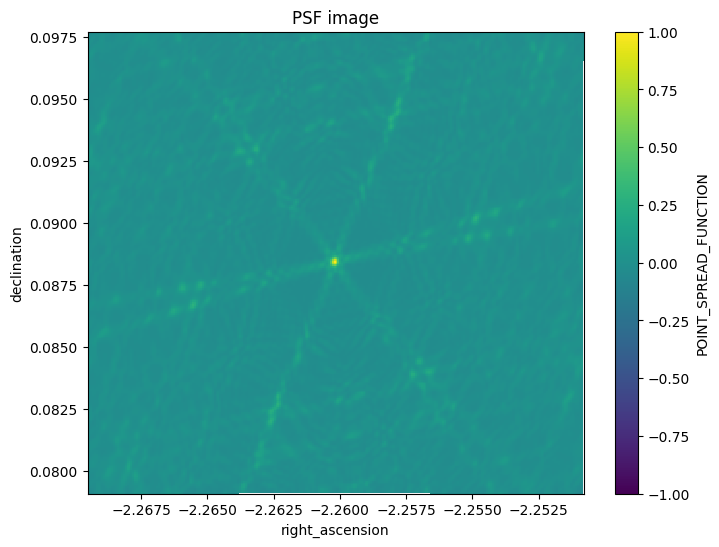

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))

data_sel = {"time":0,"frequency":1,"polarization":0}
im = psf_im["POINT_SPREAD_FUNCTION"].isel(data_sel).squeeze().plot.pcolormesh(x='right_ascension', y='declination', cmap='viridis')
plt.title('PSF image')
plt.show()
